# Entrenamiento O3

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import missingno as msn

pd.options.mode.chained_assignment = None 

from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression

#### Hacemos una función para obtenner el -promedio- de los dos modelos

In [2]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

## Hacemos una función para graficar

In [3]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

In [4]:
def ploter_title(y_test_0,X_test_0,pronosticados_0,model,titulo,ejex,ejey,color_user,ruta="./savedpicO3.png",dpi_user=300):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color=color_user)
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel(ejex)
    plt.ylabel(ejey)
    plt.title(titulo)
    plt.savefig(ruta, dpi=dpi_user)
    plt.show()

## Cargamos los modelos ya entrenados:

In [5]:
conta = 'O3'

In [6]:
model = [0 for col in range(25)]
modelq = [0 for col in range(25)]

#### Cargamos los datos:

In [7]:
data_hour_merge = pd.read_csv("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/pipeline_norberto_new/datos_modelos_O3.csv")

In [8]:
data_hour_merge[["fecha","O3_1.0_max","O3_max_frcst_1"]].head(10)

,fecha,O3_1.0_max,O3_max_frcst_1
0,2019-06-28 20:00:00,49.0,42.0
1,2019-06-28 19:00:00,59.0,46.0
2,2019-06-28 18:00:00,61.0,49.0
3,2019-06-28 17:00:00,79.0,59.0
4,2019-06-28 16:00:00,83.0,61.0
5,2019-06-28 15:00:00,83.0,79.0
6,2019-06-28 14:00:00,74.0,83.0
7,2019-06-28 13:00:00,56.0,83.0
8,2019-06-28 12:00:00,46.0,74.0
9,2019-06-28 11:00:00,35.0,56.0


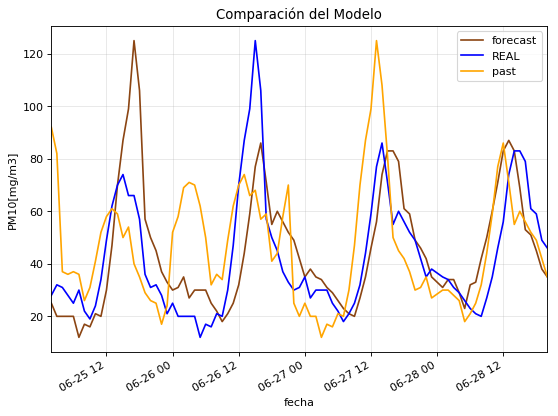

In [9]:
data_hour_merge['fecha'] =  pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M')
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca()

# df_export.(50).plot(x="fecha", y=[ "O3_y"],ax=ax,label=["O3 Medido"],color="dodgerblue")
# df_export.(60).head(100).plot(x="fecha", y=["O3_y_frcst_6"],ax=ax,label=["Pronóstico O3 a 12 horas"],color='darkblue',dashes=[6, 2])

data_hour_merge.head(90).plot(x="fecha", y=["O3_max_frcst_22"],ax=ax,label=["forecast"],color="saddlebrown")
data_hour_merge.head(90).plot(x="fecha", y=["O3_max"],ax=ax,label=["REAL"],color="blue")
data_hour_merge.head(90).plot(x="fecha", y=['O3_22.0_max'],ax=ax,label=["past"],color="orange")

#data_hour_merge.head(60).plot(x="fecha", y=["O3_pron_a_12hrs"],ax=ax,label=["Pronóstico PM10 a 12 horas"],color='maroon',dashes=[6, 2])

plt.ylabel("PM10[mg/m3]")
plt.title("Comparación del Modelo")


# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.01)
ax.grid(which='major', alpha=0.3)

plt.legend()
plt.show()

In [10]:
data_hour_merge.reset_index(inplace=True,drop=True)

In [11]:
data_hour_merge.drop("fecha",axis=1,inplace=True)

Definimos la lista de los targets:

In [12]:
target = "O3_max_frcst_"

lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [13]:
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [14]:
conta = 'O3'

In [15]:
data_hour_merge.shape

(29458, 226)

# Empezamos con el entrenamiento:

#### HORA 1 

#### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [16]:
hora = 1

dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [17]:
X_train.shape

(20620, 202)

In [18]:
X_train.columns.tolist()

['RH_min',
 'O3_2.0_min',
 'hora_10.0_max',
 'O3_22.0_mean',
 'RH_71.0_mean',
 'TMP_23.0_min',
 'RH_46.0_max',
 'O3_71.0_mean',
 'WSP_21.0_mean',
 'RH_45.0_mean',
 'O3_24.0_max',
 'O3_20.0_max',
 'NO_7.0_mean',
 'RH_45.0_max',
 'TMP_mean',
 'WSP_20.0_mean',
 'TMP_46.0_max',
 'TMP_22.0_max',
 'RH_24.0_mean',
 'O3_max',
 'hora_9.0_max',
 'TMP_min',
 'TMP_2.0_max',
 'TMP_1.0_min',
 'O3_49.0_mean',
 'TMP_71.0_mean',
 'O3_2.0_max',
 'RH_22.0_min',
 'TMP_1.0_max',
 'hora_33.0_mean',
 'TMP_24.0_mean',
 'hora_10.0',
 'O3_46.0_min',
 'hora_9.0_mean',
 'TMP_47.0_mean',
 'RH_69.0_mean',
 'O3_68.0_max',
 'WSP_67.0_mean',
 'hora_20.0_mean',
 'O3_47.0_mean',
 'hora_42.0_mean',
 'NO_7.0_max',
 'WSP_44.0_mean',
 'O3_24.0_min',
 'NO_8.0_mean',
 'hora_21.0_mean',
 'RH_48.0_max',
 'O3_69.0_max',
 'WSP_68.0_mean',
 'O3_69.0_mean',
 'TMP_2.0_min',
 'O3_23.0_min',
 'WSP_45.0_mean',
 'O3_72.0_mean',
 'TMP_0.0_mean',
 'hora_35.0_mean',
 'WSP_43.0_mean',
 'RH_24.0_max',
 'hora_45.0_mean',
 'RH_23.0_mean',
 'O3

## Modelo

In [19]:
from xgboost.sklearn import XGBRegressor

In [20]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=1500,random_state=123,max_depth=10)

In [21]:
model[0].fit(X_train, y_train)
#Predict 

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:20:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [22]:
pronos_1 = model[0].predict(X_test)

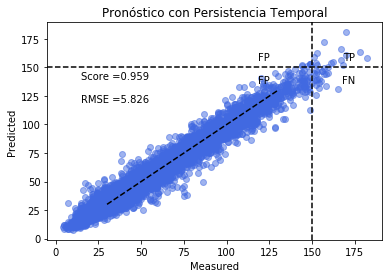

In [23]:
ploter(y_test,X_test,pronos_1,model[0])

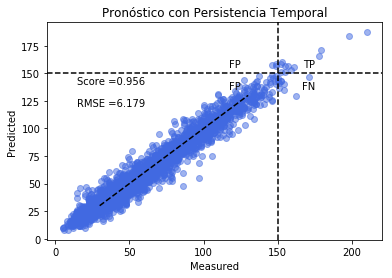

In [25]:
ploter(y_test,X_test,pronos_1,model[0])

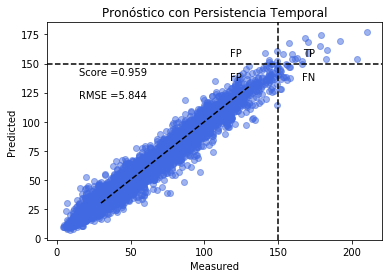

In [30]:
ploter(y_test,X_test,pronos_1,model[0])

In [31]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+ conta +'/'+ conta +'_'+ str(hora)+ 'hora.pkl')

['./modelos/O3/O3_1hora.pkl']

## Gradienst Descent:

# HORA 2

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [32]:
hora = 2

In [33]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [34]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [35]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [37]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,random_state=123,max_depth=10)

In [38]:
model[1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [39]:
pronos_2_q = model[1].predict(X_test)

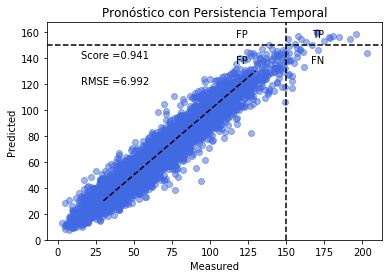

In [40]:
ploter(y_test,X_test,pronos_2_q,model[1])

In [41]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/O3/O3_2hora.pkl']

# HORA 3

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [42]:
hora = 3

In [43]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [44]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [45]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [47]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimaators=2500,n_jobs=124,random_state=123,max_depth=10, gamma=1.16)

In [48]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.16,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimaators=2500,
       n_estimators=100, n_jobs=124, nthread=None, objective='reg:linear',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [49]:
pronos_2_q = model[hora-1].predict(X_test)

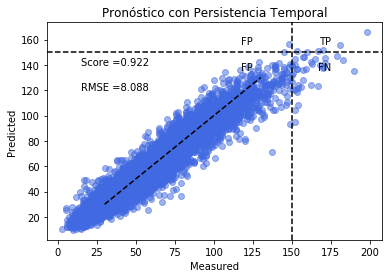

In [50]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [51]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_3hora.pkl']

# HORA 4

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [52]:
hora = 4

In [53]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [54]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [55]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [57]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [58]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [59]:
pronos_2_q = model[hora-1].predict(X_test)

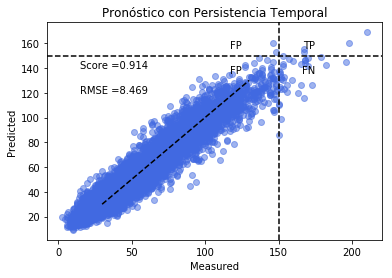

In [60]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [61]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_4hora.pkl']

# HORA 5

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [62]:
hora = 5

In [63]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [64]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [65]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [67]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [68]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:42:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [69]:
pronos_2_q = model[hora-1].predict(X_test)

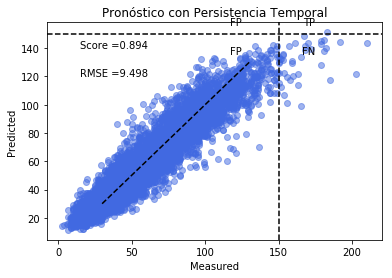

In [70]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

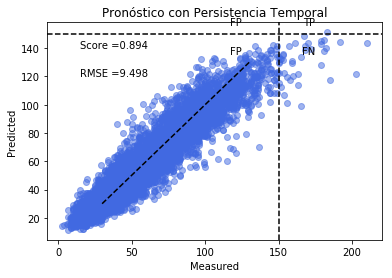

In [71]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [72]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_5hora.pkl']

# HORA 6

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [73]:
hora = 6

In [74]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [75]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [76]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [78]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [79]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:49:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [80]:
pronos_2_q = model[hora-1].predict(X_test)

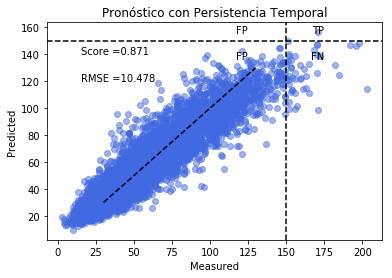

In [81]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [82]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_6hora.pkl']

# HORA 7

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [83]:
hora = 7

In [84]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [85]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [86]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [88]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [89]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [90]:
pronos_2_q = model[hora-1].predict(X_test)

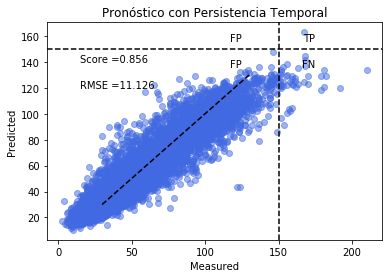

In [91]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [92]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_7hora.pkl']

# HORA 8

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [93]:
hora = 8

In [94]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [95]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [96]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [98]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [99]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [100]:
pronos_2_q = model[hora-1].predict(X_test)

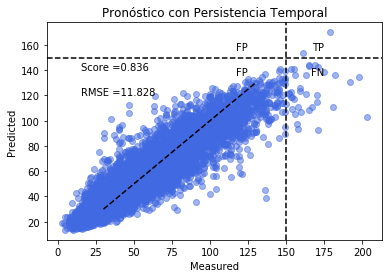

In [101]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [102]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_8hora.pkl']

# HORA 9

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [103]:
hora = 9

In [104]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [105]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [106]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [108]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [109]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [110]:
pronos_2_q = model[hora-1].predict(X_test)

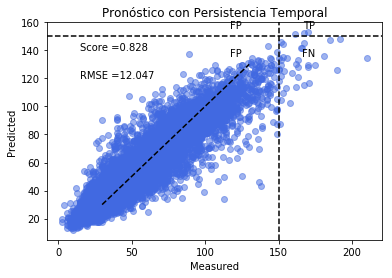

In [111]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [112]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_9hora.pkl']

# HORA 10

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [113]:
hora = 10

In [114]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [115]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [116]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [118]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [119]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:20:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [120]:
pronos_2_q = model[hora-1].predict(X_test)

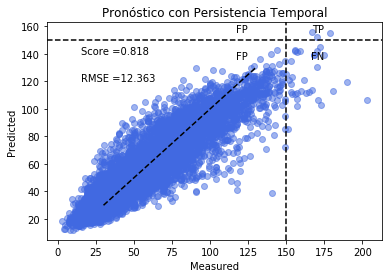

In [121]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [122]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_10hora.pkl']

# HORA 11

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [123]:
hora = 11

In [124]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [125]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [126]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [128]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [129]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [130]:
pronos_2_q = model[hora-1].predict(X_test)

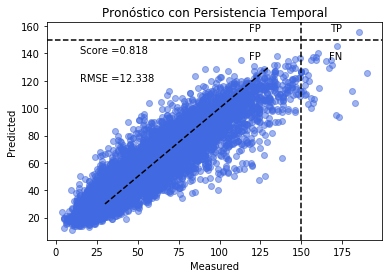

In [131]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [132]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_11hora.pkl']

# HORA 12

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [26]:
hora = 12

In [27]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [28]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [29]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [31]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [32]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [33]:
pronos_2_q = model[hora-1].predict(X_test)

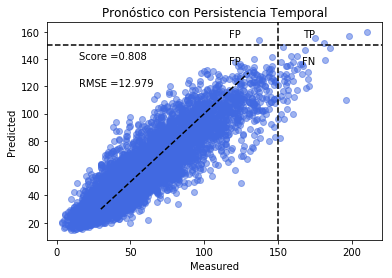

In [34]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

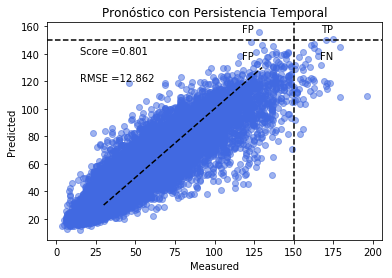

In [141]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [142]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_12hora.pkl']

# HORA 13

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [143]:
hora = 13

In [144]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [145]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [146]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [148]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [149]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [150]:
pronos_2_q = model[hora-1].predict(X_test)

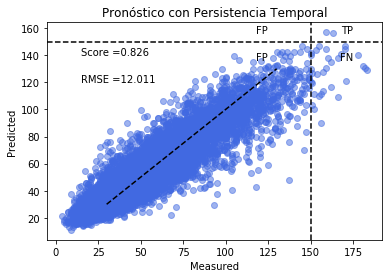

In [151]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [152]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_13hora.pkl']

# HORA 14

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [153]:
hora = 14

In [154]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [155]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [156]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [158]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [159]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [160]:
pronos_2_q = model[hora-1].predict(X_test)

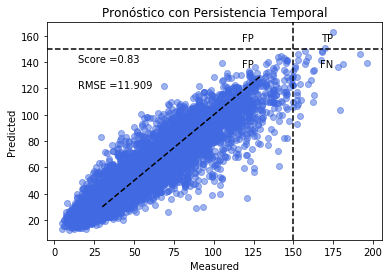

In [161]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [162]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/O3/O3_14hora.pkl']

# HORA 15

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [163]:
hora = 15

In [164]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [165]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [166]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [168]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [169]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:56:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [170]:
pronos_2_q = model[hora-1].predict(X_test)

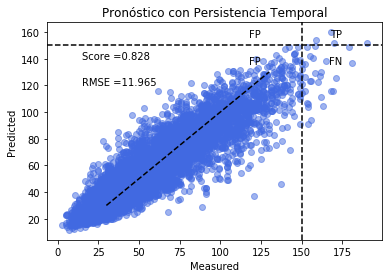

In [171]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [172]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_15hora.pkl']

# HORA 16

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [173]:
hora = 16

In [174]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [175]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [176]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [178]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [179]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [180]:
pronos_2_q = model[hora-1].predict(X_test)

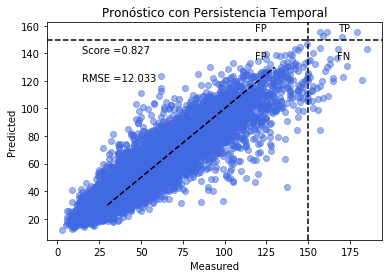

In [181]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [182]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_16hora.pkl']

# HORA 17

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [183]:
hora = 17

In [184]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [185]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [186]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [188]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [189]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:11:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [190]:
pronos_2_q = model[hora-1].predict(X_test)

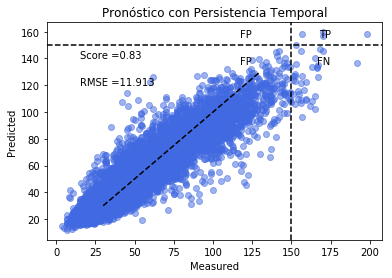

In [191]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [192]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_17hora.pkl']

# HORA 18

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [193]:
hora = 18

In [194]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [195]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [196]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [198]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [199]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:18:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [200]:
pronos_2_q = model[hora-1].predict(X_test)

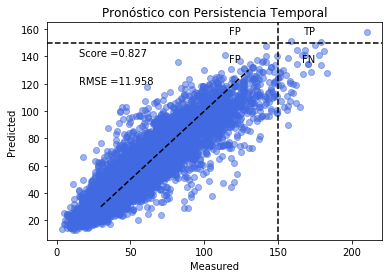

In [201]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [202]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+ conta+'_'+ str(hora) + 'hora.pkl') 

['./modelos/O3/O3_18hora.pkl']

# HORA 19

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [203]:
 hora = 19

In [204]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [205]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [206]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [208]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [209]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [210]:
pronos_2_q = model[hora-1].predict(X_test)

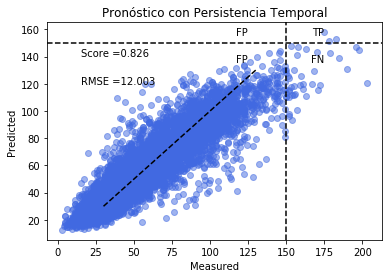

In [211]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [212]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_19hora.pkl']

# HORA 20

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [213]:
hora = 20

In [214]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [215]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [216]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [218]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [219]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [220]:
pronos_2_q = model[hora-1].predict(X_test)

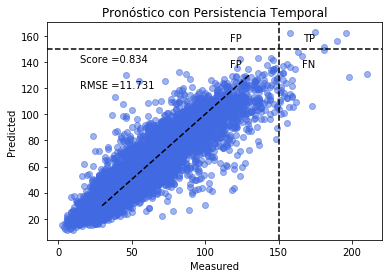

In [221]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [222]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_20hora.pkl']

# HORA 21

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [223]:
hora = 21

In [224]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [225]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [226]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [228]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [229]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [230]:
pronos_2_q = model[hora-1].predict(X_test)

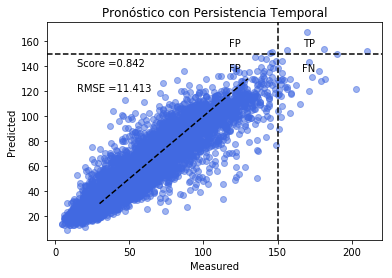

In [231]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [232]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/O3/O3_21hora.pkl']

## Hora 22

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [233]:
hora = 22

In [234]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [235]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [236]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [238]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [239]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:50:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [240]:
pronos_2_q = model[hora-1].predict(X_test)

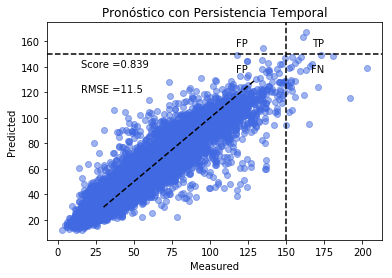

In [241]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [242]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_22hora.pkl']

# HORA 23

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [39]:
hora = 23

In [40]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [41]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [42]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [44]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [45]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:09:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [46]:
pronos_2_q = model[hora-1].predict(X_test)

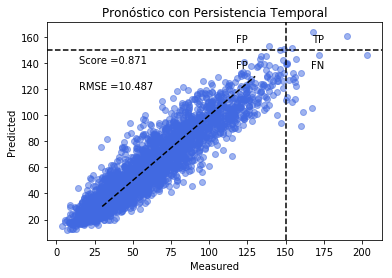

In [47]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

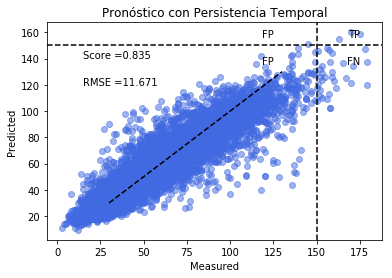

In [251]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [252]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_23hora.pkl']

# HORA 24

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [24]:
hora = 24

In [25]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [26]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [27]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [33]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=4500,n_jobs=100,random_state=123,max_depth=10)

In [34]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=4500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [35]:
pronos_2_q = model[hora-1].predict(X_test)

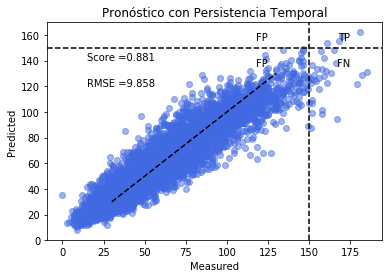

In [36]:
ploter(y_test,X_test,pronos_2_q,model[hora-1]) #XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=5)

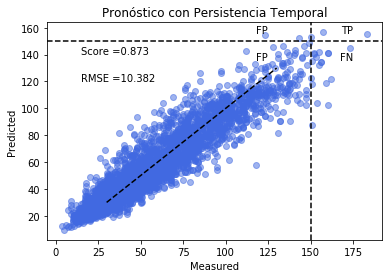

In [43]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])#XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [263]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_24hora.pkl']